In [3]:
from chebGreen import ChebGreen
import numpy as np
import matplotlib.pyplot as plt

from chebGreen.chebpy2 import Quasimatrix
from chebGreen.chebpy2.chebpy import chebfun
from chebGreen.chebpy2 import Chebfun2

# %env TF_MLC_LOGGING=1
# %env TF_CPP_MIN_LOG_LEVEL=2

In [4]:
Theta = [3,3.5,3.9,4,4.1,4.5,5]
domain = [-1,1,-1,1]
generateData = True
script = "generate_example"
example = "test_dirichlet"
dirichletBC = True
test = ChebGreen(Theta, domain, generateData, script, example, dirichletBC)

Generating dataset for example 'test_dirichlet'
Dataset found for Theta = 3.00. Skipping dataset generation.
Dataset found for Theta = 3.50. Skipping dataset generation.
Dataset found for Theta = 3.90. Skipping dataset generation.
Dataset found for Theta = 4.00. Skipping dataset generation.
Dataset found for Theta = 4.10. Skipping dataset generation.
Dataset found for Theta = 4.50. Skipping dataset generation.
Dataset found for Theta = 5.00. Skipping dataset generation.
-------------------------------------------------------------------------------

Generating chebfun2 models:
Found saved model, Loading model for example 'test_dirichlet' at Theta = 3.00
Learning a chebfun2 model for example 'test_dirichlet' at Theta = 3.00
Chebfun2 model added for example 'test_dirichlet' at Theta = 3.00

Found saved model, Loading model for example 'test_dirichlet' at Theta = 3.50
Learning a chebfun2 model for example 'test_dirichlet' at Theta = 3.50
Chebfun2 model added for example 'test_dirichlet' a

CPU times: user 14.2 s, sys: 15.6 s, total: 29.8 s
Wall time: 11.2 s


<Figure size 640x480 with 0 Axes>

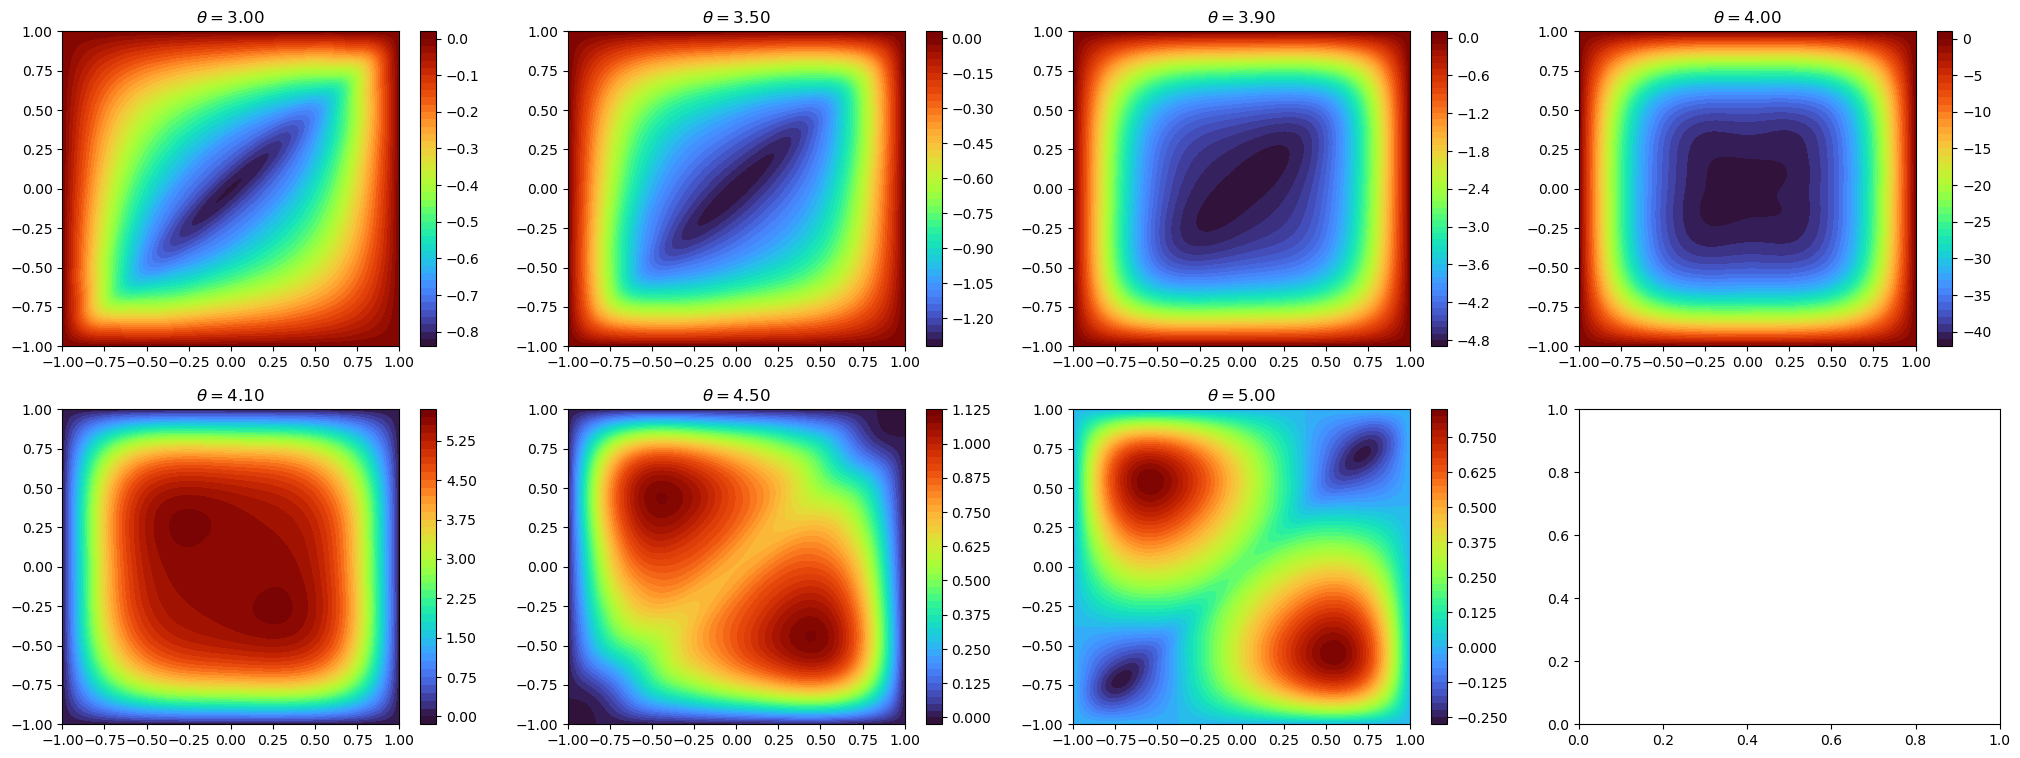

In [5]:
%%time
fig = plt.figure()

plt.tight_layout()
plt.subplots_adjust(left = 0.05, wspace=0.3, hspace=0.3)
fig, ax = plt.subplots(2,4, figsize = (25,9))

for i,t in enumerate(Theta):
    axes = ax[int(i/4),int(i%4)]
    test.G[t].plot(fig = fig, ax = axes)
    axes.set_title(f"$\\theta = {{{t:4.2f}}}$")

In [6]:
%%time
U, S, V = [],[],[]
for t in Theta:
    u,s,v = test.G[t].svd()
    U.append(u)
    S.append(s)
    V.append(v)

CPU times: user 1.88 s, sys: 5.18 s, total: 7.06 s
Wall time: 732 ms


In [17]:
t = 3
u,s,v = U[t],S[t],V[t]

[0, 1, 2, 3, 4]

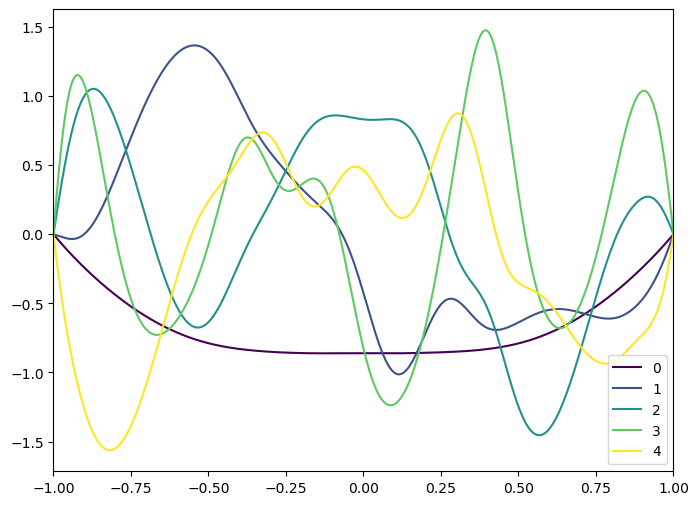

In [26]:
# i = slice(10,20)
i = slice(0,5)
# i = 16
fig = plt.figure(figsize = (8,6))
u[:,i].plot(fig = fig)
# print(np.max(u[:,i].vscale))
# plt.title(f'Firstx {i+1} left singular functions for a Laplacian')
plt.xlim([-1,1])
plt.legend(list(range(5)[i]))
# fig.savefig(f'Laplace-first.png', dpi = fig.dpi)

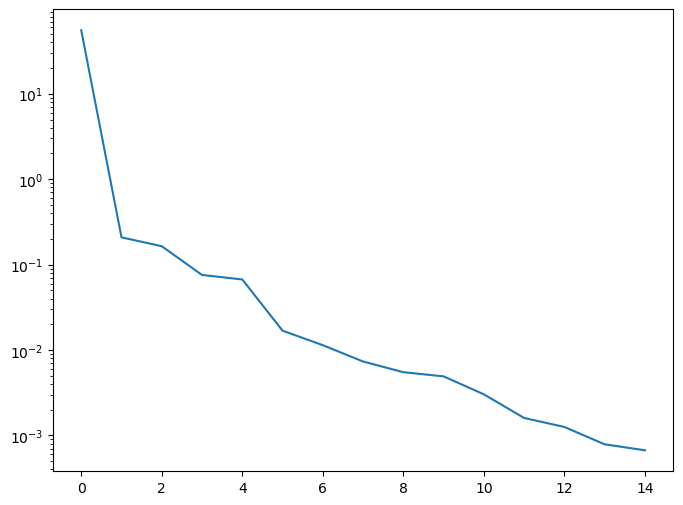

In [27]:
fig = plt.figure(figsize = (8,6))
plt.semilogy(s)

In [7]:
theta = 3.0

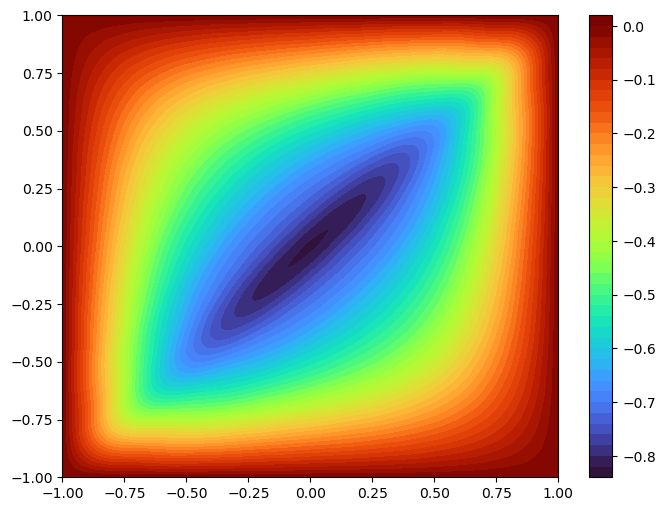

In [8]:
fig = plt.figure(figsize = (8,6))
test.G[theta].plot(fig = fig)

In [9]:
from chebGreen.greenlearning.utils import DataProcessor
from chebGreen.utils import vec2cheb
from chebGreen.chebpy2.chebpy.core.settings import ChebPreferences
from chebGreen.greenlearning.model import *

In [10]:
data = DataProcessor(f'datasets/test_dirichlet/{theta:.2f}')
# data = DataProcessor(f'datasets/mean_condition/{theta:.2f}-1000')
data.generateDataset(trainRatio = 0.95)

In [11]:
model = GreenNN()
dimension = 1
domain = [-1,1,-1,1]
layerConfig = [50,50,50,50]
activation = 'rational'
dirichletBC = True
loadPath = f'savedModels/test_dirichlet/{theta:.2f}'
# loadPath = f'savedModels/mean_condition/{theta:.2f}-1000'
model.build(dimension, domain, layerConfig, activation, dirichletBC, loadPath)

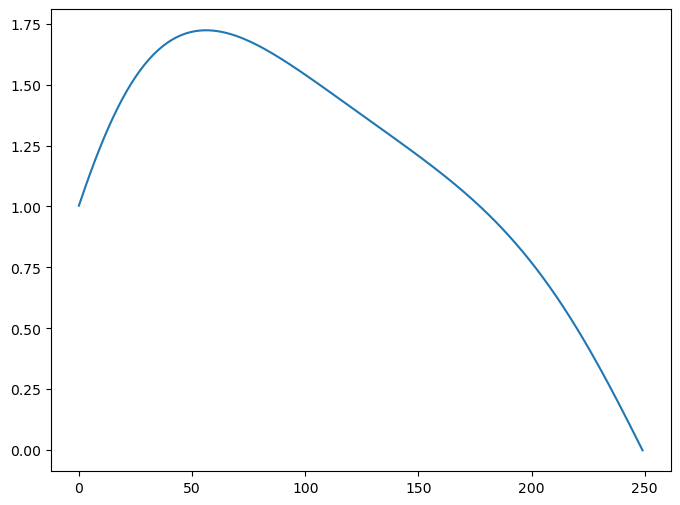

In [12]:
plt.figure(figsize = (8,6))
plt.plot(model.evaluateN(data.xU).reshape(-1))

In [13]:
def computeEmpiricalError(g, data):
    Error, UC, U0, F0 = [],[],[],[]
    for i in range(data.valDataset[1].numpy().shape[0]):
        xF, xU = data.xF, data.xU
        f, u  = data.valDataset[0].numpy()[i,:], data.valDataset[1].numpy()[i,:]
        f0, u0 = vec2cheb(f,xF), vec2cheb(u,xU)
        prefs = ChebPreferences()
        prefs.eps = 1e-8
        un = chebfun(lambda x: model.evaluateN(x), domain = f0.domain, prefs = prefs)
        u0 -= un
        uc = g.integralTransform(f0)
        # prefs = ChebPreferences()
        # prefs.eps = 1e-8
        # un = chebfun(lambda x: model.evaluateN(x), domain = f0.domain, prefs = prefs)
        # uc = uc + un
        error = (uc - u0).abs()
        Error.append(error)
        UC.append(uc)
        U0.append(u0)
        F0.append(f0)
    return Error, UC, U0, F0

In [14]:
Error, UC, Response, Forcing = computeEmpiricalError(test.G[theta],data)

In [15]:
e = 0
for error,u0 in zip(Error,Response):
    e += error.sum()/u0.abs().sum()
e /= len(Error)

In [16]:
print(f"Percentage relative error = {np.mean(e)*100}%")

Percentage relative error = 1.631901079606861%


In [17]:
E = Quasimatrix(data = np.array(Response))
F = Quasimatrix(data = np.array(Forcing))

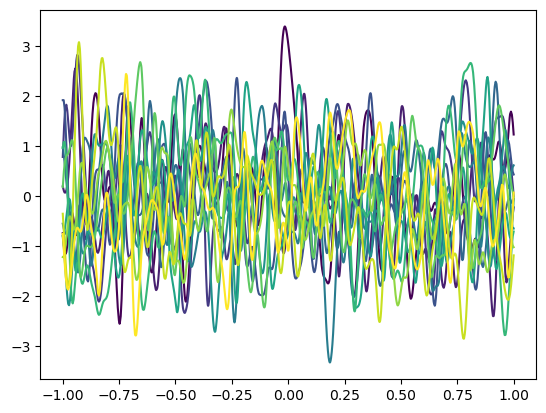

In [18]:
F.plot()

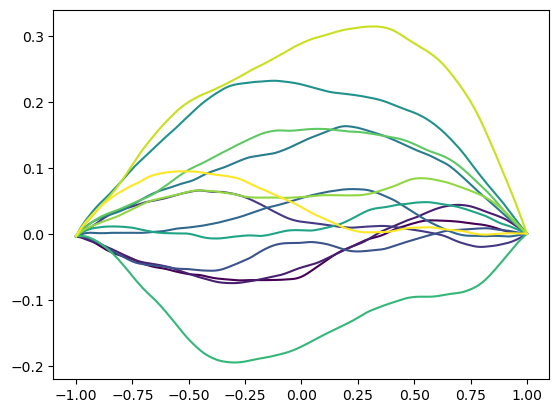

In [19]:
E.plot()